#Scalar Coupling (Acoplamiento Escalar)
El scalar coupling es una interacción fundamental en la espectroscopía de resonancia magnética nuclear (RMN), donde núcleos magnéticamente activos acoplados entre sí intercambian información sobre su entorno químico a través de electrones compartidos en enlaces covalentes. Este acoplamiento se refleja en la separación de las señales espectrales en múltiplos llamados constantes de acoplamiento $J$, que se miden en Hertz (Hz).


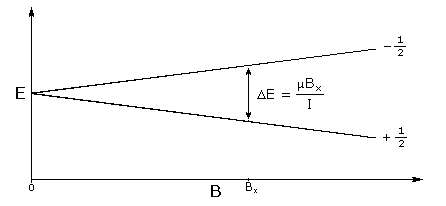

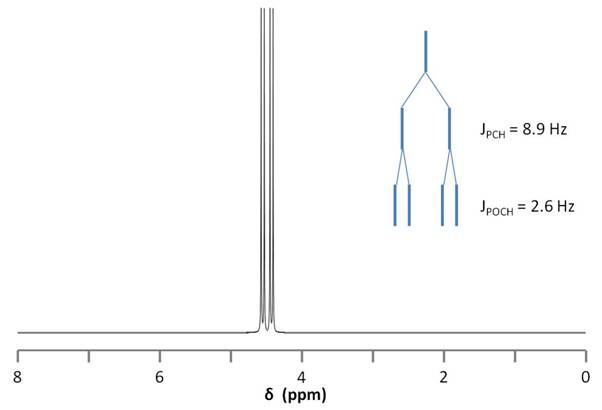

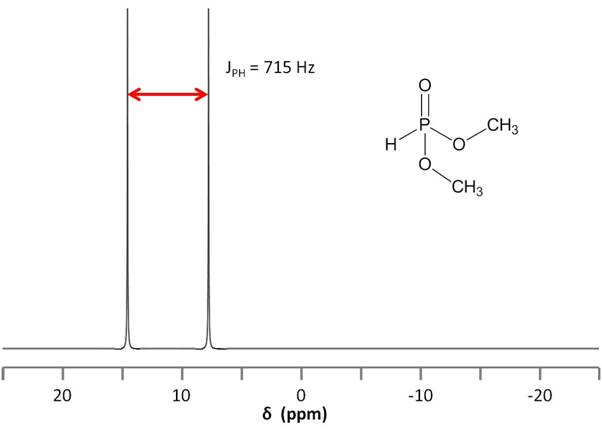

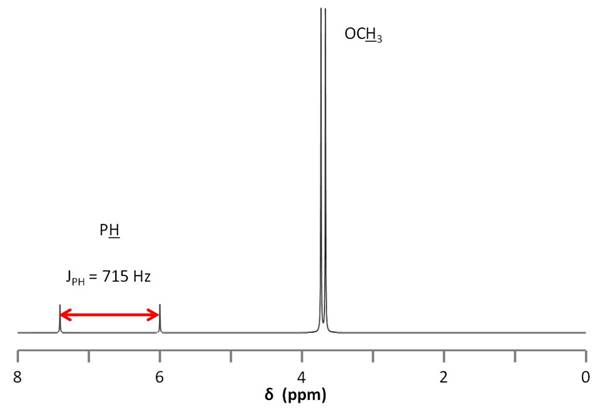

##Cuantificación
Debido a lo variado de las moléculas, no solo en su estructura sino en su composición, esta cantidad puede depender de la naturaleza del enlace [1], la geometría de la molécula[] o el entorno químico[]. El problema con esto es que usar modelos físicos conocidos para esta tarea resulta prácticamente imposible por la dínamica a la que están sujetos los electrones dentro de la molécula o por las interacciones a las que pueden estar sujetas estas mismas moléculas para una aplicación en especial.

##Acoplamiento escalar como una variable a predecir
Por la flexibilidad y cantidad de datos disponibles en el plantemiento del problema de kaggle, el acoplamiento escalar puede ser clasificado de muchas maneras, cada una según se adapte al método de predición empleado. En este proyecto final se presentarán dos variantes.

# Scalar Coupling Constants with GCN
En este modelo, cada molécula es representada por una gráfica torch_geometric.data.data.Data. Los átomos se mapean a nodos con atributos: elemento, masa atómica, número atómico, posición absoluta en la molécula, y los enlazamientos J entre átomos se representan por edges con atributos: tipo de enlazamiento, número de átomos entre los átomos enlazados, separación relativa de los átomos. Estos objetos Data son la entrada de una red convolucional gráfica (GCN), cuyas capas convolucionales son GANConv (Graph Attention Networks), seguidas de capas lineales para arrojar el atributo de nodo. Los nodos con edges compartidos son enviados a unas últimas capas lineales para predecir el valor de la constante J del enlazamiento.

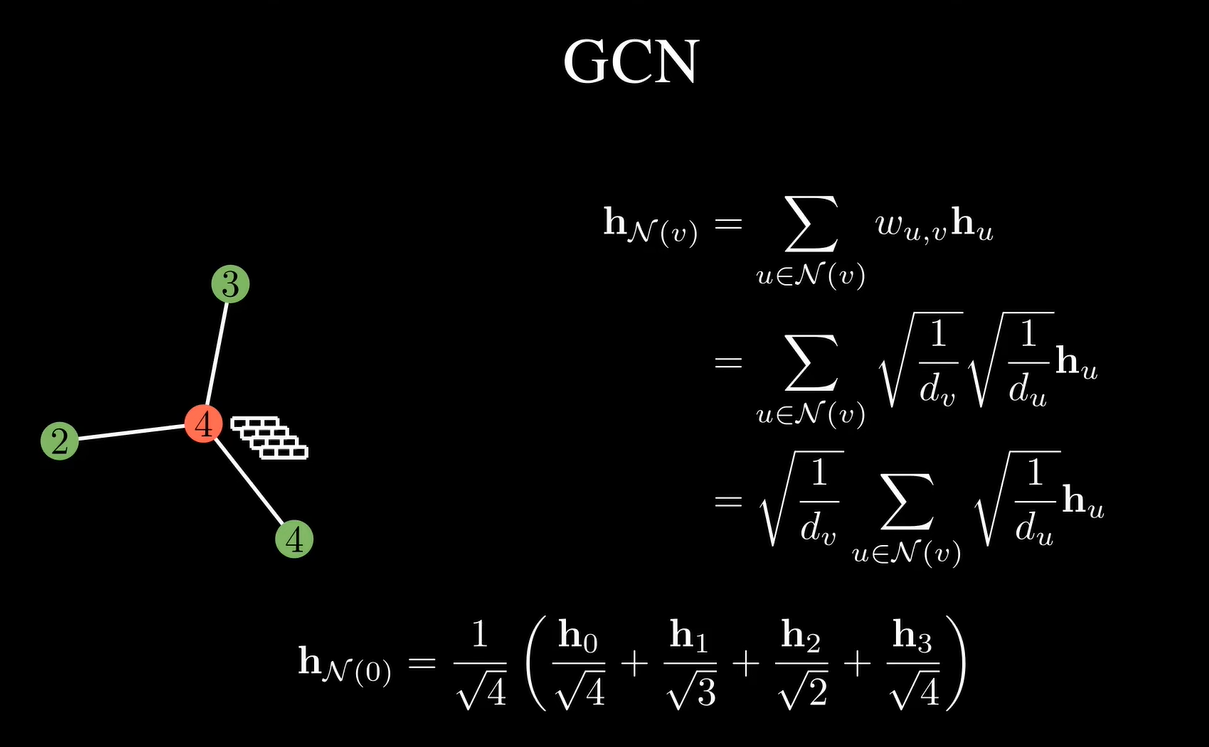

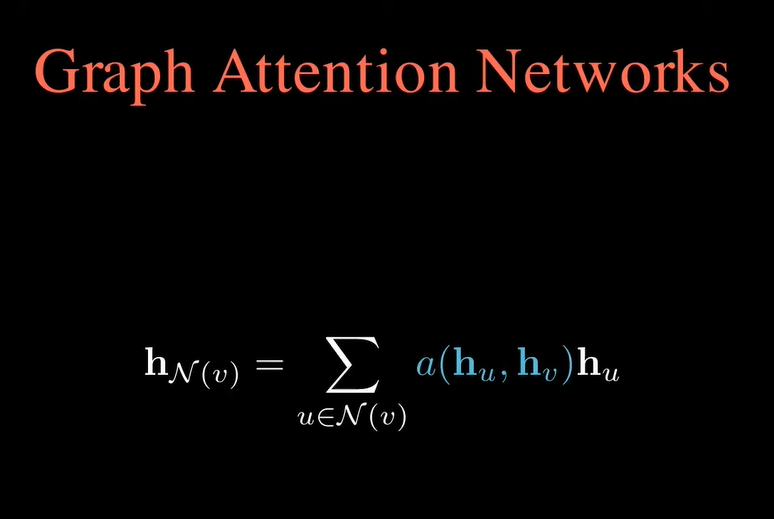

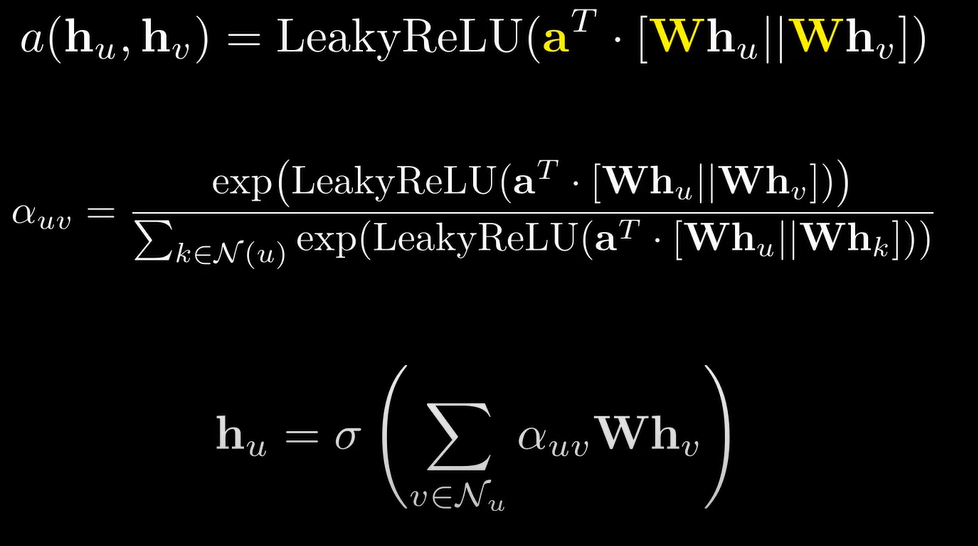

# Imports

In [21]:
!pip install rdkit
!pip install torch
!pip install torch_geometric

In [22]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
# For drawing network
import networkx as nx

#from rdkit import Chem
#from rdkit.Chem import rdmolops

import sklearn.metrics as metrics

In [23]:
# For a single graph, can also use
# Batch for multiple data.
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
# For converting Data graph object to drawable network
from torch_geometric.utils.convert import to_networkx
import torch.nn.functional as F

# Scalar Coupling Constants with GCN

## Data representation and dataloader

In [24]:
class Molecule():
  # Node (atom) dictionaries
  node_attr_size = 8
  elements_dict = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4}
  masses_dict = {'H': 1.00784, 'C': 12.011, 'N': 14.0067,
                 'O': 15.999, 'F': 18.998403}
  number_dict = {'H': 1, 'C': 6, 'N': 7, 'O': 8, 'F': 9}
  electroneg_dict = {'H': 2.2, 'C': 2.55, 'N': 3.04, 'O': 3.44, 'F': 3.98}

  # Edges (bond) dictionaries
  edges_attr_size = 6
  separation_dict = {'1': 0, '2': 1, '3': 3}
  couplings_dict = {'1JHC': 0, '1JHN': 1,
              '2JHH': 2, '2JHN': 3, '2JHC': 4,
              '3JHH': 5, '3JHC': 6, '3JHN': 7}
  def __init__(self, mol_name, train_mol_df, str_mol_df):
    self.name = mol_name
    self.train_df = train_mol_df
    self.str_df = str_mol_df
    self.graph = self.graph_builder()


  def graph_builder(self):
    train_df = self.train_df
    str_df = self.str_df
    edge_index = np.array([train_df['atom_index_0'],
                           train_df['atom_index_1']])
    j_constants = train_df['scalar_coupling_constant']

    ## Edge attributes
    edge_attributes = []
    for _, row in train_df.iterrows():
      edge_attr = []
      id1, id2 = row['atom_index_0'], row['atom_index_1']
      type_str = row['type']

      # Bond separation
      edge_attr.append(Molecule.separation_dict[type_str[0]])
      # Coupling type
      edge_attr.append(Molecule.couplings_dict[type_str])
      # Spatial separation
      separations = self.relative_separation(id1, id2)
      for sep in separations:
        edge_attr.append(sep)
      edge_attributes.append(edge_attr)

    ## Node attributes
    node_attributes = [np.random.normal(size=Molecule.node_attr_size) for _
                       in range(max(str_df['atom_index'].unique()) + 1)]

    for i, num_row in enumerate(str_df.iterrows()):
      node_attr = []
      row = num_row[1]
      element = row['atom']
      # Element
      node_attr.append(Molecule.elements_dict[element])
      # Atomic mass
      node_attr.append(Molecule.masses_dict[element])
      # Atomic number
      node_attr.append(Molecule.number_dict[element])
      # Electronegativity
      node_attr.append(Molecule.electroneg_dict[element])
      # Spatial separation from molecule center
      separations = self.absolute_separation(row)
      for sep in separations:
        node_attr.append(sep)
      node_attributes[i] = node_attr

    dtype = torch.float
    node_attributes = torch.tensor(node_attributes, dtype=dtype)
    edge_attributes = torch.tensor(edge_attributes, dtype=dtype)
    edge_index = torch.tensor(edge_index)
    j_constants = torch.tensor(np.array(j_constants), dtype=dtype)
    graph = Data(x=node_attributes, edge_index=edge_index,
                edge_attr=edge_attributes, y=j_constants)
    return graph

  def visualize(self):
    vis = to_networkx(self.graph)
    # Minimizes energy of spring system
    # distribution = nx.kamada_kawai_layout(vis)
    distribution = nx.circular_layout(vis)
    node_color = self.graph.x[:, 0]
    node_color_map = {0: 'blue', 1: 'brown', 2: 'gray', 3: 'gold', 4: 'violet'}
    edge_color_map = {0: '#efedf5', 1: '#dadaeb', 2: '#bcbddc', 3: '#9e9ac8',
                4: '#807dba', 5: '#6a51a3', 6: '##54278f', 7: '#3f007d'}
    edge_colors = []
    for coupling in self.graph.edge_attr[:, 0]:
      edge_colors.append(edge_color_map[coupling.item()])

    node_colors = []
    for element in self.graph.x[:, 0]:
      node_colors.append(node_color_map[element.item()])

    fig = plt.figure(figsize=(3, 3))
    network = nx.draw(vis, distribution,
                      node_color=node_colors,
                      edge_color=edge_colors)
    plt.show()


  def relative_separation(self, id1, id2):
    str_df = self.str_df
    filter1 = str_df['atom_index'] == id1
    filter2 = str_df['atom_index'] == id2
    row1 = str_df[filter1]
    row2 = str_df[filter2]

    coords = ['x', 'y', 'z']
    separations = []
    for coord in coords:
      sep = np.abs(row1[coord].iloc[0] - row2[coord].iloc[0])
      separations.append(sep)

    distance = np.sqrt(np.sum([u**2 for u in separations]))
    return *separations, distance

  @staticmethod
  def absolute_separation(row):
    coords = {'x', 'y', 'z'}
    separations = []
    for coord in coords:
      sep = row[coord]
      separations.append(sep)

    distance = np.sqrt(np.sum([u**2 for u in separations]))
    return *separations, distance

In [40]:
def MolecularDataLoader(train_df, structure_df,
                        mol_names, train_ratio = 0.8):
  molecules_list = []
  num_molecules = len(mol_names)
  for i, mol_name in enumerate(mol_names):
    filter = train_df['molecule_name'] == mol_name
    train_mol_df = train_df[filter]
    print(i)

    filter = structure_df['molecule_name'] == mol_name
    str_mol_df = structure_df[filter]

    molecule = Molecule(mol_name, train_mol_df, str_mol_df)
    print(round(100 * i / num_molecules, 2))
    molecules_list.append(molecule)
  np.random.shuffle(molecules_list)

  comp_ratio = (1 - train_ratio) / 2
  split_index = int(train_ratio * len(molecules_list))
  comp_index = int(comp_ratio * len(molecules_list)) + 1

  train_data = molecules_list[:split_index]
  val_data = molecules_list[split_index:split_index + comp_index]
  test_data = molecules_list[split_index + comp_index:]
  return train_data, val_data, test_data

## Model


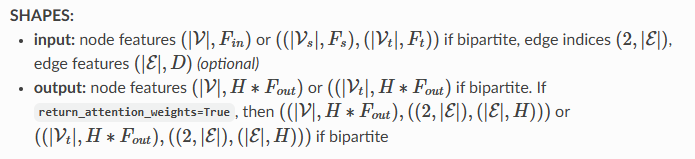

In [26]:
from torch_geometric.nn.conv import GATConv

In [27]:
class CouplingSage(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim,
               edges_attr_dim, p_dropout=0):
    super(CouplingSage, self).__init__()

    # Node layers
    self.input_layer = GATConv(input_dim, hidden_dim,
                               edge_dim=edges_attr_dim, heads=1)

    self.hidden_layers = nn.ModuleList()
    for _ in range(1):
      self.hidden_layers.append(nn.Sequential(GATConv(hidden_dim, hidden_dim,
                                                      heads=1)))

    self.final_layers = nn.Sequential(
        nn.Linear(hidden_dim, hidden_dim), nn.Dropout(p_dropout),
        nn.Linear(hidden_dim, output_dim)
    )

    self.input_layer = nn.Linear(input_dim, hidden_dim)

    # Edge layers
    self.edge_layers = nn.Sequential(
        nn.Linear(2 + Molecule.edges_attr_size, hidden_dim),
        nn.Dropout(p_dropout),
        nn.Linear(hidden_dim, output_dim)
    )
    self.p_dropout = p_dropout


  def forward(self, graph):
    x, edge_index, edge_attr = graph.x, graph.edge_index, graph.edge_attr
    #x = self.input_layer(x, edge_index, edge_attr)
    x = self.input_layer(x)
    x = self.sig_dropout(x)

    for layer in self.hidden_layers[0]:
      x = layer(x, edge_index)
      x = self.sig_dropout(x)

    x = self.final_layers(x).view(-1)

    node_pairs = self.edge_extractor(x, edge_index, edge_attr)
    node_pairs = self.sig_dropout(node_pairs)

    E = self.edge_layers(node_pairs)
    E = E.view(-1)
    return E


  def edge_extractor(self, x, edge_index, edge_attr):
    node_pairs = []
    for id1, id2, edge in zip(edge_index[0], edge_index[1], edge_attr):
      id1, id2 = id1.item(), id2.item()
      pair = [x[id1].item(), x[id2].item()]
      node_pairs.append(pair)

      for attr in edge:
        pair.append(attr)

    node_pairs = torch.tensor(node_pairs)
    return node_pairs

  def sig_dropout(self, x):
    x = F.sigmoid(x)
    x = F.dropout(x, p=self.p_dropout, training=self.training)
    return x

## Inputs

### Data normalization

In [28]:
train_df = pd.read_csv('./train.csv')
structures_df = pd.read_csv('./structures.csv')
mol_names = train_df['molecule_name'].unique()
print(len(mol_names))

85012


In [29]:
dfs = [train_df, structures_df]

In [30]:
# mols_used = 10000
# mol_names = mol_names[:mols_used]

for i, df in enumerate(dfs):
  filter = df['molecule_name']
  last_atom_id = 1 + filter[filter == mol_names[-1]].index[-1]
  df = df.iloc[:last_atom_id]
  dfs[i] = df

In [31]:
# Train data
dfs[0].describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06
mean,2.329538e+06,1.335677e+01,5.881245e+00,1.591591e+01
std,1.344960e+06,3.269432e+00,4.993794e+00,3.493466e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,-4.476050e+01
25%,1.164769e+06,1.100000e+01,2.000000e+00,-2.551462e-01
50%,2.329538e+06,1.300000e+01,5.000000e+00,2.280350e+00
75%,3.494306e+06,1.600000e+01,8.000000e+00,7.389100e+00
max,4.659075e+06,2.800000e+01,2.800000e+01,2.077090e+02


<Figure size 700x700 with 0 Axes>

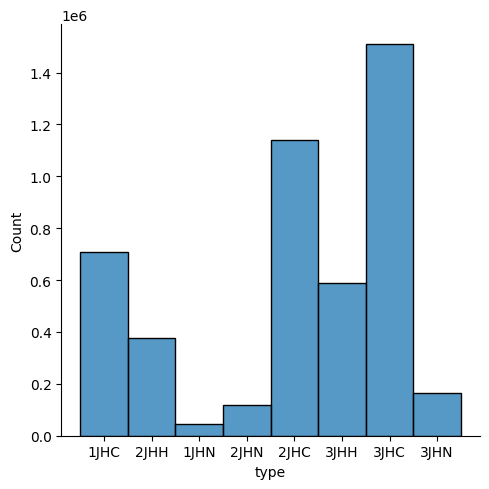

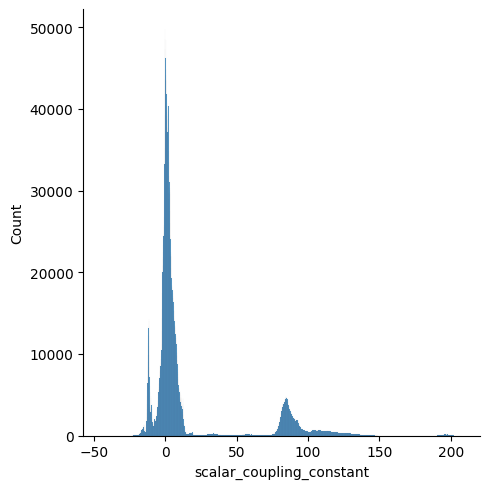

In [32]:
# First headers are molecule name and indices
fig = plt.figure(figsize=(7, 7))
for header in dfs[0].columns[4:]:
  sb.displot(dfs[0][header])

# From the slice above, only scalar_coupling_constant is numeric
j_constants = dfs[0]['scalar_coupling_constant']
dfs[0]['scalar_coupling_constant'] = (j_constants - j_constants.mean()) / j_constants.std()

<Figure size 700x700 with 0 Axes>

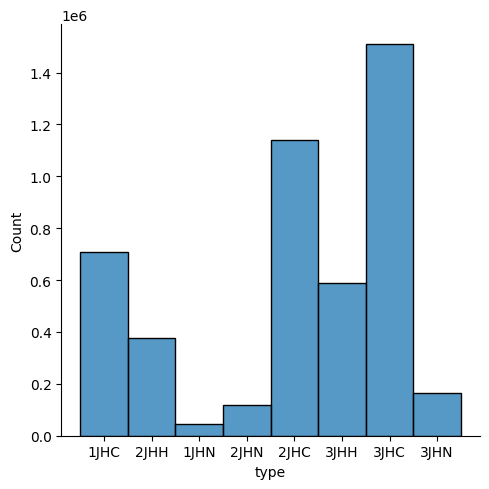

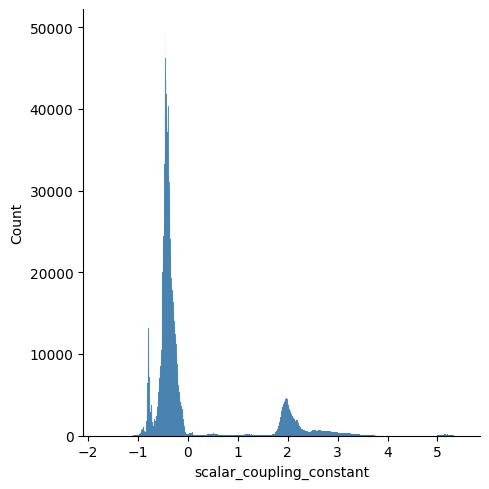

In [33]:
# Normalized train data
fig = plt.figure(figsize=(7, 7))
for header in dfs[0].columns[4:]:
  sb.displot(dfs[0][header])

In [34]:
dfs[0].describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.659076e+06,4.659076e+06,4.659076e+06,4.659076e+06
mean,2.329538e+06,1.335677e+01,5.881245e+00,6.061186e-16
std,1.344960e+06,3.269432e+00,4.993794e+00,1.000000e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,-1.736854e+00
25%,1.164769e+06,1.100000e+01,2.000000e+00,-4.628943e-01
50%,2.329538e+06,1.300000e+01,5.000000e+00,-3.903160e-01
75%,3.494306e+06,1.600000e+01,8.000000e+00,-2.440787e-01
max,4.659075e+06,2.800000e+01,2.800000e+01,5.490052e+00


In [35]:
# Structure data
dfs[1].describe()

,atom_index,x,y,z
count,2.358859e+06,2.358859e+06,2.358859e+06,2.358859e+06
mean,8.757263e+00,9.496089e-02,-3.335638e-01,6.239079e-02
std,5.592449e+00,1.655405e+00,1.989332e+00,1.445879e+00
min,0.000000e+00,-9.234889e+00,-9.933938e+00,-9.134765e+00
25%,4.000000e+00,-8.746160e-01,-1.826104e+00,-8.424758e-01
50%,9.000000e+00,5.184055e-02,-4.034906e-01,1.092872e-02
75%,1.300000e+01,1.116163e+00,1.373852e+00,9.393909e-01
max,2.800000e+01,9.382240e+00,1.018196e+01,7.894733e+00


<ipython-input-36-f1dc56300d86>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs[1][header] = norm_col


<Figure size 700x700 with 0 Axes>

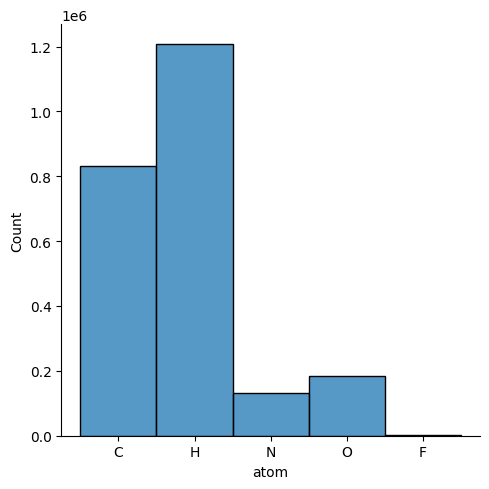

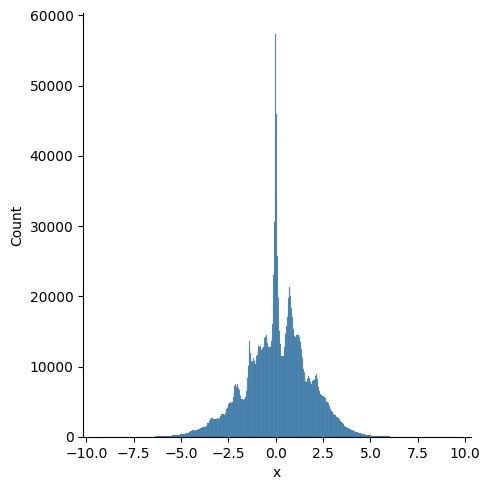

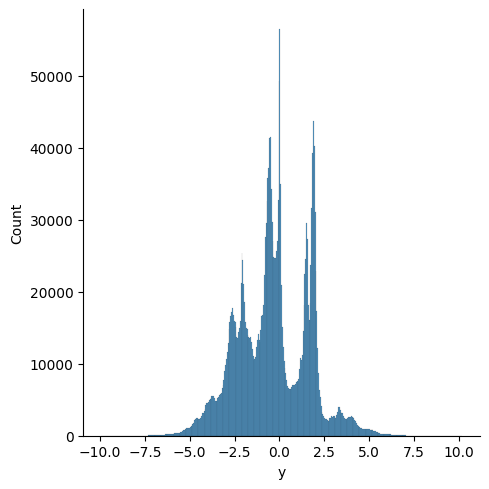

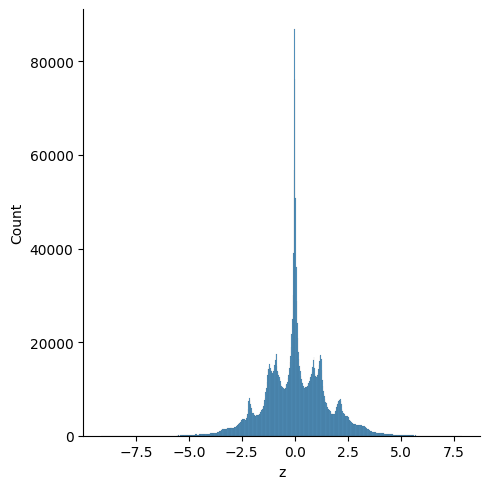

In [36]:
fig = plt.figure(figsize=(7, 7))

# First headers are molecule name and indices
for header in dfs[1].columns[2:]:
  sb.displot(dfs[1][header])

for header in dfs[1].columns[3:]:
  col = dfs[1][header]
  norm_col = (col - col.mean()) / col.std()
  dfs[1][header] = norm_col

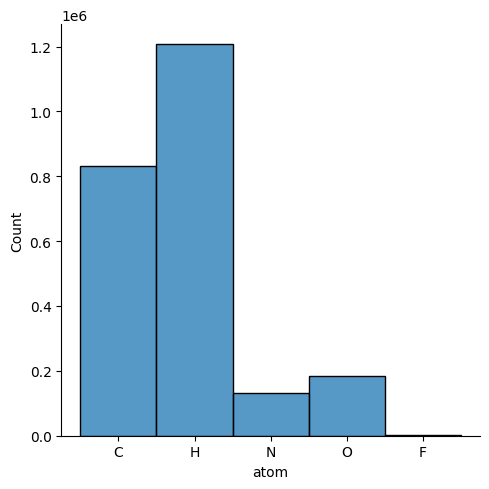

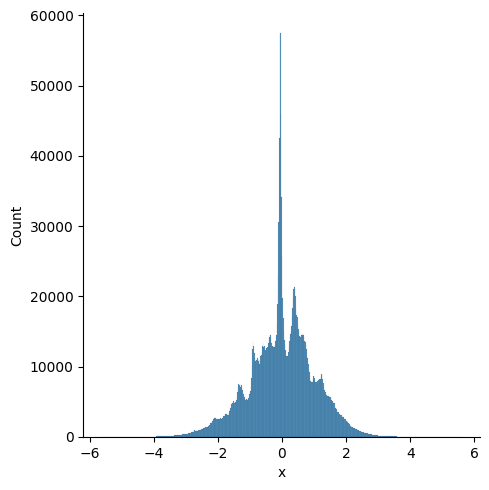

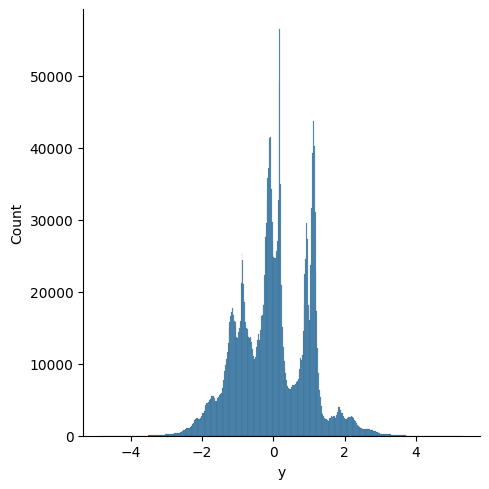

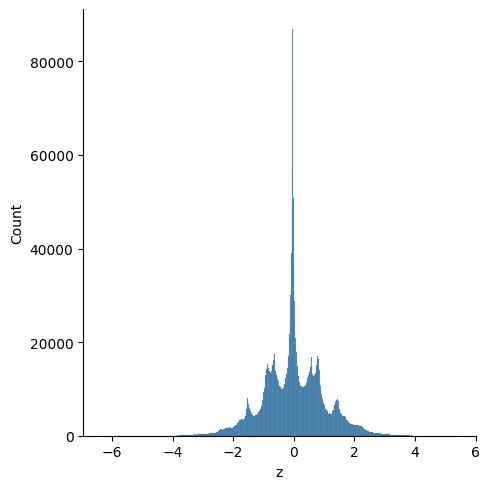

In [37]:
# Normalized structure data
for header in dfs[1].columns[2:]:
  sb.displot(dfs[1][header])

In [38]:
dfs[1].describe()

,atom_index,x,y,z
count,2.358859e+06,2.358859e+06,2.358859e+06,2.358859e+06
mean,8.757263e+00,-6.352192e-17,-9.716251e-17,1.012109e-17
std,5.592449e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000e+00,-5.635991e+00,-4.825928e+00,-6.360945e+00
25%,4.000000e+00,-5.857036e-01,-7.502720e-01,-6.258247e-01
50%,9.000000e+00,-2.604820e-02,-3.515086e-02,-3.559225e-02
75%,1.300000e+01,6.168894e-01,8.582857e-01,6.065516e-01
max,2.800000e+01,5.610275e+00,5.285955e+00,5.417012e+00


In [ ]:
train_data, val_data, test_data = MolecularDataLoader(dfs[0], dfs[1], mol_names)
train_data[0].graph.edge_attr

Streaming output truncated to the last 5000 lines.
2.99
2544
2.99
2545
2.99
2546
2.99
2547
3.0
2548
3.0
2549
3.0
2550
3.0
2551
3.0
2552
3.0
2553
3.0
2554
3.0
2555
3.01
2556
3.01
2557
3.01
2558
3.01
2559
3.01
2560
3.01
2561
3.01
2562
3.01
2563
3.01
2564
3.02
2565
3.02
2566
3.02
2567
3.02
2568
3.02
2569
3.02
2570
3.02
2571
3.02
2572
3.03
2573
3.03
2574
3.03
2575
3.03
2576
3.03
2577
3.03
2578
3.03
2579
3.03
2580
3.03
2581
3.04
2582
3.04
2583
3.04
2584
3.04
2585
3.04
2586
3.04
2587
3.04
2588
3.04
2589
3.05
2590
3.05
2591
3.05
2592
3.05
2593
3.05
2594
3.05
2595
3.05
2596
3.05
2597
3.05
2598
3.06
2599
3.06
2600
3.06
2601
3.06
2602
3.06
2603
3.06
2604
3.06
2605
3.06
2606
3.07
2607
3.07
2608
3.07
2609
3.07
2610
3.07
2611
3.07
2612
3.07
2613
3.07
2614
3.07
2615
3.08
2616
3.08
2617
3.08
2618
3.08
2619
3.08
2620
3.08
2621
3.08
2622
3.08
2623
3.09
2624
3.09
2625
3.09
2626
3.09
2627
3.09
2628
3.09
2629
3.09
2630
3.09
2631
3.09
2632
3.1
2633
3.1
2634
3.1
2635
3.1
2636
3.1
2637
3.1
2638
3.1
2639
3.1


In [ ]:
print(len(train_data), len(val_data), len(test_data))
indexs = np.random.choice(80, 3)
for i in indexs:
  train_data[i].visualize()

## Training

In [ ]:
def accuracy(x, y):
  return np.log(metrics.mean_squared_error(x, y))

In [ ]:
def graph_epoch_loss(epoch_loss, epoch_loss_val):
  epoch_loss = np.array(epoch_loss)
  epoch_loss_test = np.array(epoch_loss_val)
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.plot(epoch_loss, label='Epoch Loss')
  ax.plot(epoch_loss_val, label='Epoch Loss Val')
  title = f"Epoch loss\n{epochs = }, {lr = }"
  ax.set(title=title, xlabel='Epoch', ylabel='MSE loss')

  plt.legend()
  plt.savefig('./' + title + '.png')
  plt.show()

In [ ]:
lr = 1E-3
epochs = 5
model = CouplingSage(input_dim=Molecule.node_attr_size,
                     hidden_dim=30, output_dim=1,
                     edges_attr_dim=Molecule.edges_attr_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
len_train_data = len(train_data)
len_val_data = len(val_data)
epoch_loss = []
epoch_loss_val = []
for epoch in range(epochs):
  epoch_loss_avg = 0
  for i, molecule in enumerate(train_data):
    model.train()

    graph = molecule.graph
    pred = model(graph)

    loss = criterion(pred, graph.y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss_avg += accuracy(pred.detach(), graph.y.detach()) / len_train_data
  epoch_loss_val_avg = 0
  for molecule in val_data:
    pred = model(molecule.graph)
    expected = molecule.graph.y
    epoch_loss_val_avg += accuracy(pred.detach(),
                                      expected.detach()) / len_val_data
  epoch_loss_val.append(epoch_loss_val_avg)
  epoch_loss.append(epoch_loss_avg)
  print(f"{epoch = }, epoch_loss = {epoch_loss[-1]}, "
        f"epoch_loss_test = {epoch_loss_val[-1]}")

In [ ]:
graph_epoch_loss(epoch_loss, epoch_loss_val)

### Validation

In [ ]:
epoch_error_test = 0
for molecule in test_data:
  pred = model(molecule.graph)
  expected = molecule.graph.y
  epoch_error_test += accuracy(pred.detach(), expected.detach()) / len(test_data)
print(epoch_error_test)

In [ ]:
coupling_constants = torch.tensor([])
predictions = torch.tensor([])
for molecule in test_data[:20]:
  expected = molecule.graph.y * j_constants.std() + j_constants.mean()
  coupling_constants = torch.cat((coupling_constants, expected))

  predicted = model(molecule.graph)
  predicted = predicted * j_constants.std() + j_constants.mean()
  predictions = torch.cat((predictions, predicted.clone().detach()))

for i in np.random.choice(len(predictions), 3):
  print(f"Expected: {coupling_constants[i]}\nPredicted: {predictions[i]}\n")

In [ ]:
sb.displot(coupling_constants)
sb.displot(predictions)